## Variational Autoencoder

In this notebook I will implement the varitional autoencoder from this paper https://arxiv.org/pdf/1312.6114

**Setup**

**Decoder:** (Appendix C)

- $\theta = \{W_{3},W_{4},W_{5},b_{3},b_{4},b_{5}\}$
- $\log(p(x|z)) = \log(\mathcal{N}(x,\mu,\sigma^{2} \mathbb{I}))$
- $h = \tanh(W_{3}z + b)$
- $\mu = W_{4}h + b_{4}$
- $\log(\sigma^{2}) = W_{5}h + b_{5}$

**Encoder:** (Appendix C)

*Note*: Here he weights and biases are different - don't confuse them with the weights and biases above

- $\phi = \{W_{3},W_{4},W_{5},b_{3},b_{4},b_{5}\}$
- $\log(q(z|x)) = \log(\mathcal{N}(z,\mu,\sigma^{2} \mathbb{I}))$
- $h = \tanh(W_{3}x + b)$
- $\mu = W_{4}h + b_{4}$
- $\log(\sigma^{2}) = W_{5}h + b_{5}$

The idea here is that you can use neural networks to get the parameters of your distribution from conditional

In [80]:
import torch.nn as nn
import torch.nn.functional as F
import torch

# Defining the gaussian parameter Neural Network - this will help us map our conditional into target distribution
class GaussianParameterMLP(nn.Module):
    def __init__(self, conditional_dim, hidden_dim, output_dim) -> None:
        super().__init__()

        self.hidden_layer = nn.Sequential(
            nn.Linear(conditional_dim, hidden_dim, bias=True),
            nn.Tanh()
        )

        self.mean_network = nn.Linear(hidden_dim, output_dim, bias=True)
        self.log_variance_network = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, conditional):
        hidden_layer = self.hidden_layer(conditional)
        mean = self.mean_network(hidden_layer)
        log_variance = self.log_variance_network(hidden_layer)
        variance = torch.exp(log_variance)
        
        # Returning the mean and the diagonal (assumption) covariance matrix
        return mean, torch.diag_embed(variance)

test_gaussian_mlp = GaussianParameterMLP(5, 3, 2)
test_gaussian_mlp.eval()

test_input = torch.rand((1, 5))
mean, variance = test_gaussian_mlp(test_input)

torch.distributions.MultivariateNormal(mean, covariance_matrix=variance).sample()

tensor([[0.7299, 1.5028]])

## Loading the data

Here I will use the MNIST dataset to try to replicate the experiment they have done in the paper

Image shape: torch.Size([100, 1, 28, 28])
Classes shape: torch.Size([100])


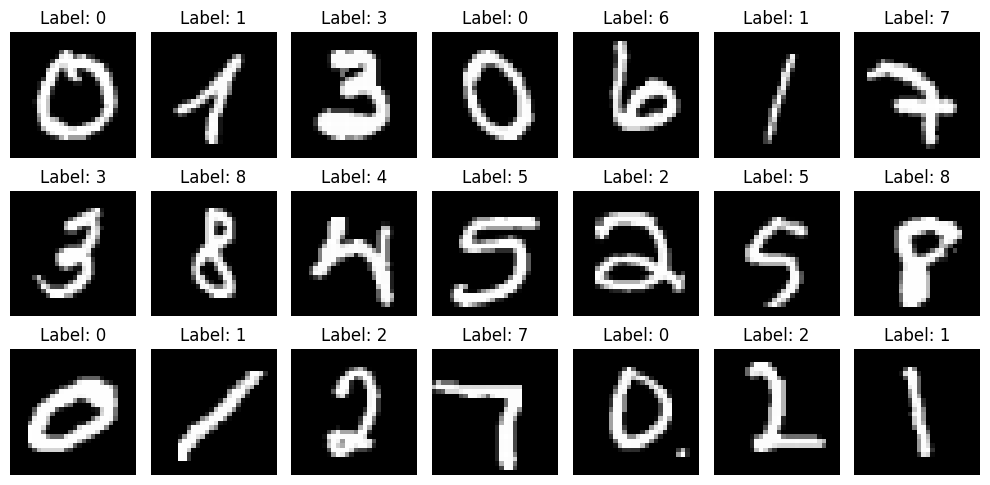

In [64]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Transformation: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

# Get a batch
images, classes = next(iter(train_loader))
print("Image shape:", images.shape)   # [100, 1, 28, 28]
print("Classes shape:", classes.shape)

# Undo normalization for visualization
images = images * 0.3081 + 0.1307

# Plot 3x7 grid of digits
fig, axs = plt.subplots(3, 7, figsize=(10, 5))
for i in range(3):
    for j in range(7):
        idx = i * 7 + j
        axs[i, j].imshow(images[idx][0], cmap='gray')
        axs[i, j].set_title(f"Label: {classes[idx].item()}")
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

Step 0: Loss = 1158.7072
Step 20: Loss = 360.1642
Step 40: Loss = 55.6945
Step 60: Loss = -71.1221
Step 80: Loss = -140.9816
Step 100: Loss = -48.7529
Step 120: Loss = -255.9319
Step 140: Loss = -243.3832
Step 160: Loss = -341.7073
Step 180: Loss = -253.1920
Step 200: Loss = -347.3604
Step 220: Loss = -286.8855
Step 240: Loss = -335.4261
Step 260: Loss = -369.6701
Step 280: Loss = -475.2155
Step 300: Loss = -449.4944
Step 320: Loss = -392.7398
Step 340: Loss = -432.6113
Step 360: Loss = -399.3477
Step 380: Loss = -434.9864
Step 400: Loss = -338.6183
Step 420: Loss = -205.7979
Step 440: Loss = -501.4318
Step 460: Loss = -407.1082
Step 480: Loss = -531.5479
Step 500: Loss = -427.3264
Step 520: Loss = -484.4463
Step 540: Loss = -275.7005
Step 560: Loss = -250.2747
Step 580: Loss = -597.3014


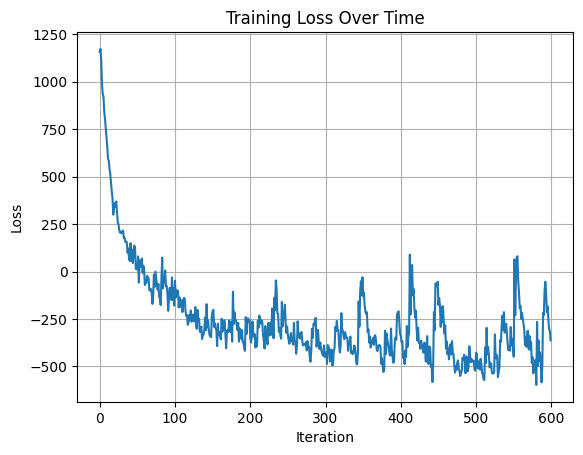

In [153]:
# Training the encoder
latent_dimension = 10  # One of the datapoints form the paper
hidden_dimension = 500  # From the paper
data_dimension = 28 * 28  # Flattened-out output dimension
noise_size = 2  # Just to test out the non-trivial case of L > 1

def sample_latents(means_encoder, variances_encoder, noise):
    # Get the std diagonals - tensor should be of shape (100, latent_dimension)
    std_encoder_diagonals = torch.sqrt(variances_encoder.diagonal(dim1=-2, dim2=-1))

    # Reparameterize the noise
    # z should be a tensor of size (100, noise_size, latent_dimension)
    # This concludes sampling from the encoder
    return means_encoder.unsqueeze(1) + std_encoder_diagonals.unsqueeze(1) * noise.unsqueeze(0)

def compute_kl_term(means_encoder, variances_encoder):
    # Compute the square means, extract variances, and get log of variances
    square_means = (means_encoder ** 2)
    variances = variances_encoder.diagonal(dim1=-2, dim2=-1)
    log_variances = torch.log(variances)

    # Here simplified the latent_dimension since the paper was summing over the constant 1 for mathematical convenience reasons
    kl_term = 0.5 * (latent_dimension + log_variances.sum(dim=-1) - variances.sum(dim=-1) - square_means.sum(dim=-1))
    return kl_term

def compute_log_likelihood(x, means_decoder, variances_decoder):
    # See why you can do that in the below writeup - it has to do with the factorization of multivariate gaussian distribution
    # We are initializing many normal distributions in parallel 
    distributions = torch.distributions.Normal(
        loc=means_decoder, 
        scale=torch.sqrt(variances_decoder).diagonal(dim1=-2, dim2=-1)
    )

    # This is needed to make L copies of the data to evaluate the log probability on latents that resulted from different noise
    x_copies = x.unsqueeze(1).expand(-1, noise_size, -1)
    log_probs = distributions.log_prob(x_copies)

    # First, take a sum over the factored elements of x, then take an average over the noise levels
    return log_probs.sum(dim=-1).mean(dim=-1)

def train_step(x, encoder_mlp, decoder_mlp, noise_distribution, optimizer, step, losses):
    optimizer.zero_grad()

    # Get means and variances of the image for encoding - parameters for the distribution p(z|x)
    means_encoder, variances_encoder = encoder_mlp(x)

    # Get noise - should be of shape (noise_size, latent_dimension)
    noise = noise_distribution.sample((noise_size,))

    z = sample_latents(means_encoder, variances_encoder, noise)
    z_flattened = z.view(-1, z.size(-1))

    means_decoder, variances_decoder = decoder_mlp(z_flattened)
    means_decoder = means_decoder.view(x.size(0), noise_size, data_dimension)
    variances_decoder = variances_decoder.view(x.size(0), noise_size, data_dimension, data_dimension)

    kl_term = compute_kl_term(means_encoder, variances_encoder)
    log_likelihood = compute_log_likelihood(x, means_decoder, variances_decoder)

    loss = -(log_likelihood + kl_term).mean()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if step % 20 == 0:
        print(f"Step {step}: Loss = {loss.item():.4f}")

# Initialize modules
encoder_mlp = GaussianParameterMLP(data_dimension, hidden_dimension, latent_dimension)
decoder_mlp = GaussianParameterMLP(latent_dimension, hidden_dimension, data_dimension)
noise_distribution = torch.distributions.MultivariateNormal(
    torch.zeros(latent_dimension), 
    covariance_matrix=torch.eye(latent_dimension)
)
optimizer = torch.optim.Adam(list(encoder_mlp.parameters()) + list(decoder_mlp.parameters()), lr=1e-3)

# Main training loop
losses = []
for step, (images, _) in enumerate(train_loader):
    x = images.view(images.size(0), -1)  # Flatten the images into vectors
    train_step(x, encoder_mlp, decoder_mlp, noise_distribution, optimizer, step, losses)

# Plot loss curve
plt.plot(losses)
plt.title("Training Loss Over Time")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()